In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import seaborn as sns


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
diagnosis_df = pd.read_csv('/home/antpc/cough_detection/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['Patient number', 'Diagnosis'])
diagnosis_df.head(4)

,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


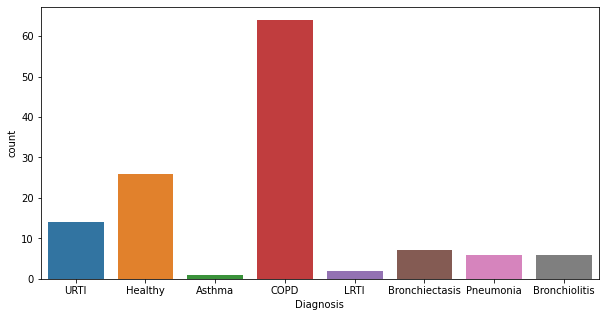

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(diagnosis_df['Diagnosis'])

In [6]:
df_no_diagnosis = pd.read_csv('../input/respiratory-sound-database/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')
df_no_diagnosis.head(5)

FileNotFoundError: [Errno 2] File ../input/respiratory-sound-database/demographic_info.txt does not exist: '../input/respiratory-sound-database/demographic_info.txt'

In [ ]:
df =  df_no_diagnosis.join(diagnosis_df.set_index('Patient number'), on = 'Patient number', how = 'left')
df.head(5)

In [7]:
root = '/home/antpc/cough_detection/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,176,2b3,Lr,mc,AKGC417L
0,130,1p3,Al,mc,AKGC417L
0,207,3b2,Tc,mc,AKGC417L
0,130,2p5,Pr,mc,AKGC417L
0,169,1b1,Lr,sc,Meditron


In [8]:
class Diagnosis():
    def __init__ (self, id, diagnosis, image_path):
        self.id = id
        self.diagnosis = diagnosis 
        self.image_path = image_path   

In [9]:
def get_wav_files():
    audio_path = '/home/antpc/cough_detection/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
    files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
    wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
    wav_files = sorted(wav_files)
    return wav_files, audio_path


In [10]:
def diagnosis_data():
    diagnosis = pd.read_csv('/home/antpc/cough_detection/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv')
  
    wav_files, audio_path = get_wav_files()
    diag_dict = { 101 : "URTI"}  
    diagnosis_list = []
  
    for index , row in diagnosis.iterrows():
        diag_dict[row[0]] = row[1]     

    c = 0
    for f in wav_files:
        diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))  
        c+=1  

    return diagnosis_list

In [11]:
import librosa

def audio_features(filename): 
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))  
 
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
    concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
    return concat

def data_points():
    labels = []
    images = []

    to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

    count = 0
    for f in diagnosis_data():
        #print(count)
        labels.append(to_hot_one[f.diagnosis]) 
        images.append(audio_features(f.image_path))
        #count+=1

    return np.array(labels), np.array(images)

In [12]:
from sklearn.model_selection import train_test_split

def preprocessing(labels, images):    

  # Remove Asthma and LRTI
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      

  # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)  

  # Format new data
    y_train = np.reshape(y_train, (y_train.shape[0], 6))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 6))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

    return X_train, X_test, y_train, y_test

In [13]:
from os import listdir
from os.path import isfile, join
from tensorflow.keras.utils import plot_model,to_categorical

labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)

/home/antpc/.local/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


# CNN model

In [14]:
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=4, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 733 samples, validate on 184 samples
Epoch 1/100
733/733 [==============================] - 2s 2ms/sample - loss: 0.8113 - accuracy: 0.8336 - val_loss: 0.3687 - val_accuracy: 0.8967
Epoch 2/100
733/733 [==============================] - 1s 717us/sample - loss: 0.6958 - accuracy: 0.8377 - val_loss: 0.3789 - val_accuracy: 0.8750
Epoch 3/100
733/733 [==============================] - 1s 712us/sample - loss: 0.5987 - accuracy: 0.8417 - val_loss: 0.3029 - val_accuracy: 0.8913
Epoch 4/100
733/733 [==============================] - 1s 727us/sample - loss: 0.5814 - accuracy: 0.8417 - val_loss: 0.3611 - val_accuracy: 0.8967
Epoch 5/100
733/733 [==============================] - 1s 728us/sample - loss: 0.5271 - accuracy: 0.8649 - val_loss: 0.4572 - val_accuracy: 0.8424
Epoch 6/100
733/733 [==============================] - 1s 714us/sample - loss: 0.5157 - accuracy: 0.8540 - val_loss: 0.2634 - v

Epoch 54/100
733/733 [==============================] - 1s 717us/sample - loss: 0.1007 - accuracy: 0.9604 - val_loss: 0.1500 - val_accuracy: 0.9402
Epoch 55/100
733/733 [==============================] - 1s 719us/sample - loss: 0.1098 - accuracy: 0.9618 - val_loss: 0.1754 - val_accuracy: 0.9239
Epoch 56/100
733/733 [==============================] - 1s 753us/sample - loss: 0.1402 - accuracy: 0.9468 - val_loss: 0.1399 - val_accuracy: 0.9348
Epoch 57/100
733/733 [==============================] - 1s 738us/sample - loss: 0.1080 - accuracy: 0.9536 - val_loss: 0.1392 - val_accuracy: 0.9457
Epoch 58/100
733/733 [==============================] - 1s 723us/sample - loss: 0.1021 - accuracy: 0.9659 - val_loss: 0.1770 - val_accuracy: 0.9293
Epoch 59/100
733/733 [==============================] - 1s 721us/sample - loss: 0.0995 - accuracy: 0.9604 - val_loss: 0.1617 - val_accuracy: 0.9402
Epoch 60/100
733/733 [==============================] - 1s 723us/sample - loss: 0.0882 - accuracy: 0.9714 - val_

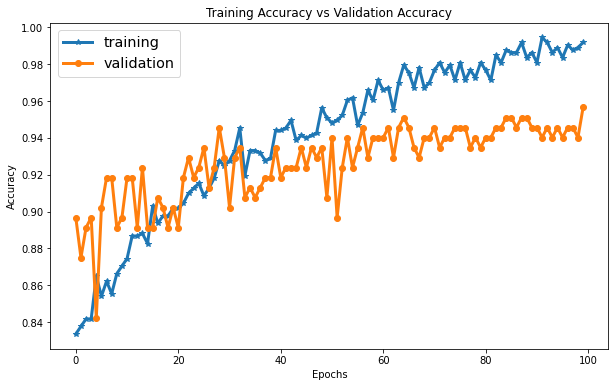

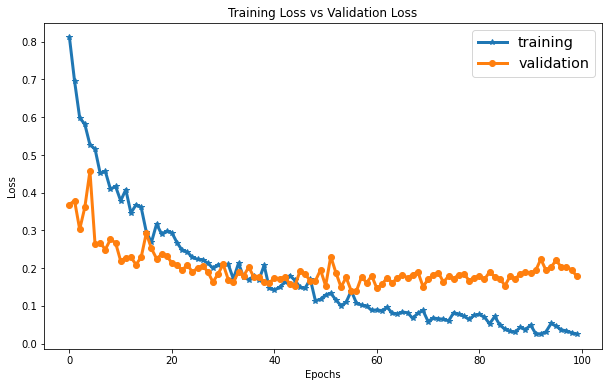

In [21]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

In [23]:
model.save('/home/antpc/cough_detection/codes/')
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model_resp.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /home/antpc/cough_detection/codes/assets
INFO:tensorflow:Converted 10 variables to const ops.


In [24]:
#optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [26]:
tflite_model_quant = converter.convert()
with tf.io.gfile.GFile('model_resp_quant.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Converted 10 variables to const ops.


# Model Confusion Matrix

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
rac = roc_auc_score(y_testclass, classpreds)
print('The ROC-AUC score obtained : {}'.format(rac))